In [1]:
import torch
import numpy as np
import torch.nn as nn
import tiktoken
import torch.nn.functional as F
torch.manual_seed(42)

# Final Model Implementation and Training with TikToken Tokenizer
- instead of using karpathy's naive tokenizer, I experimented with GPT-2 tokenizer from tik token library

## Utilities - Tokenizer, Vocabulary

In [2]:
import torch
torch.manual_seed(42)

def get_batch(data,context_window=8,batch_size=8,DEVICE='cpu'):
    idx = torch.randint(len(data)-context_window,(batch_size,)) 
    X = torch.stack([data[i:i+context_window] for i in idx])
    y = torch.stack([data[i+1:i+context_window+1] for i in idx])
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    return X,y

@torch.no_grad()
def estimate_loss(model,train_data,val_data,eval_iters,context_windo,batch_size,device):
    out = {}
    splits = ['train','val']
    model.eval()
    for idx,data in enumerate([train_data,val_data]):
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,y = get_batch(data=data,context_window=context_windo,batch_size=batch_size,DEVICE=device)
            _,loss = model(X,y)
            losses[k] = loss
        out[splits[idx]] = losses.mean()
    model.train()
    return out

class custom_tokenizer():
    def __init__(self, data_path) -> None:
        self.data_path = data_path
        # Initialize the GPT-2 BPE tokenizer
        self.enc = tiktoken.get_encoding("gpt2")
        self.load()

    def load(self):
        try:
            with open(self.data_path, 'r', encoding='utf-8') as f:
                text = f.read()
        except Exception as e:
            print(f"Error loading file: {e}")
            text = ""

        self.data = text
    
    def encode(self, text: str):
        return self.enc.encode(text)
    
    def decode(self, ids: list):
        return self.enc.decode(ids)

    def _size_(self):
        return self.enc.n_vocab # Returns 50257
    
    def get_coded_data_split(self):
        print("Encoding data with BPE (this may take a moment)...")
        data_ids = self.encode(self.data)
        
        data_tensor = torch.tensor(data_ids, dtype=torch.long)
        
        n = int(0.9 * len(data_tensor))
        train, val = data_tensor[:n], data_tensor[n:]
        
        print(f"Token count: Train {len(train):,}, Val {len(val):,}")
        return train, val
        
import math
def get_lr(it,config):
    # 1. Linear Warmup Phase
    if it < config.warmup_iters:
        return config.max_lr * (it + 1) / config.warmup_iters
    
    # 2. If we go past max_iters, just return min_lr
    if it > config.max_iters:
        return min_lr
    
    decay_ratio = (it - config.warmup_iters) / (config.max_iters - config.warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # ranges 0..1
    return config.min_lr + coeff * (config.max_lr - config.min_lr)
    

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

class FeedForward(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embed,4*config.embed),
            nn.ReLU(),
            nn.Linear(4*config.embed,config.embed),
            nn.Dropout(config.dropout)
        )
    def forward(self,x):
        return self.net(x)

class causalAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.embed % config.n_heads == 0
        self.c_attn = nn.Linear(config.embed,3*config.embed,bias=False)
        self.proj = nn.Linear(config.embed,config.embed,bias=False)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_heads = config.n_heads
        self.n_embed = config.embed
    def forward(self,x):
        B,T,C = x.shape

        kqv = self.c_attn(x) ## x(B,T,C) -> kqv (B,T,3*C)

        k,q,v = kqv.split(self.n_embed,dim=2) ## each matrix has dimension (B,T,C)

        k = k.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## k(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)
        q = q.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## q(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)
        v = v.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## v(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)

        ##attention calculation for each head we want (T,head_size) which we'll concatenate

        wei = q @ k.transpose(-2,-1) * (k.shape[-1]**-0.5) ## wei: (B,n_heads,T,T)
        trill = torch.tril(torch.ones(T,T,device=x.device)).view(1,1,T,T)
        wei = wei.masked_fill(trill == 0,float('-inf'))

        wei = F.softmax(wei,dim=-1)
        wei = self.attn_dropout(wei)
        
        y = wei@v

        y = y.transpose(1,2).contiguous().view(B,T,C)

        out = self.proj(y)
        out = self.resid_dropout(out)
        return out

class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.sa = causalAttention(config)
        self.ffwd = FeedForward(config)

        self.ln1 = nn.LayerNorm(config.embed)
        self.ln2 = nn.LayerNorm(config.embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class NanoGPT(nn.Module):
    def __init__(self, config, vocab_size): # Added config
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, config.embed)
        self.position_embedding_table = nn.Embedding(config.block_size, config.embed)
        self.dropout = nn.Dropout(config.dropout)
        # 3. THE BLOCKS: A stack of Transformer Blocks (Sequential is fine here)
        self.blocks = nn.Sequential(*[
            Block(config) for _ in range(config.n_layer)
        ])
        
        # 4. FINAL LAYER NORM: Standard Pre-Norm practice
        self.ln_f = nn.LayerNorm(config.embed)
        
        # 5. LM HEAD: Projects from embedding dim back to vocab size
        self.lm_head = nn.Linear(config.embed, vocab_size)

        self.block_size = config.block_size

    def forward(self, idx, labels=None):
        B, T = idx.shape

        pos_idx = torch.arange(T, device=idx.device) 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(pos_idx) # (T, C)
        
        x = tok_emb + pos_emb # (B, T, C)
        x = self.dropout(x)
        x = self.blocks(x) # (B, T, C)
        
        x = self.ln_f(x) # (B, T, C)
        
        logits = self.lm_head(x) # (B, T, vocab_size)

        if labels is None:
            loss = None
        else:
            # Reshape for Cross Entropy (Standard PyTorch requirement)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            labels = labels.view(-1)
            loss = F.cross_entropy(logits, labels)

        return logits, loss

    def generate(self, idx, max_length):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_length):
            # NEW: Crop context to the last block_size tokens
            # If idx is longer than block_size, position embeddings will crash!
            idx_cond = idx[:, -self.block_size:]
            
            # Get the predictions
            logits, loss = self(idx_cond)
            
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [4]:
from dataclasses import dataclass

@dataclass
class config:
    n_layer = 6
    block_size = 256
    embed = 384
    n_heads = 6
    batch_size = 32
    dropout = 0.3
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    max_iters_training = 5000
    max_lr = 1e-4        
    min_lr = max_lr/10
    warmup_iters = 100   
    max_iters = max_iters_training 
    eval_iters = 260
    data_path = r'/kaggle/input/tiny-shakespeare-karpathys-repo/tiny_shakespeare.txt'

# 1. Setup Data & Model
tokenizer = custom_tokenizer(data_path=config.data_path)
train_data, val_data = tokenizer.get_coded_data_split()

Encoding data with BPE (this may take a moment)...
Token count: Train 304,222, Val 33,803


In [5]:
import torch
from tqdm.notebook import tqdm, trange 

# # 1. Setup Data & Model
# tokenizer = custom_tokenizer(data_path=config.data_path)
# train_data, val_data = tokenizer.get_coded_data_split()

model = NanoGPT(config, tokenizer._size_()) # Ensure this method returns int
model.to(config.device)

# 2. Setup Optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=config.max_lr)
trLoss,valLoss = [],[]

best_metric = float('inf') # Start at infinity so first loss is always "better"
patience = 5               # How many evals to wait before stopping
trigger = 0
print('Starting Training....')

# 3. Training Loop
training_loop = trange(config.max_iters_training, desc='Training') 

for step in training_loop:
    # A. Update Learning Rate
    lr = get_lr(step,config)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # B. Evaluation (Every eval_iters)
    if step % config.eval_iters == 0 or step == config.max_iters_training - 1:
        losses = estimate_loss(model, train_data, val_data, config.eval_iters, config.block_size, config.batch_size, config.device)
        training_loop.set_postfix(train_loss=losses['train'].item(), val_loss=losses['val'].item(), lr=lr)
        tqdm.write(f"Step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trLoss.append(losses['train'].item())
        valLoss.append(losses['val'].item())
        if(losses['val'] < best_metric):
            best_metric = losses['val']
            trigger = 0
            torch.save(model.state_dict(),'nanoGPT_tiktoken.pth')
        else:
            trigger+=1

    if trigger > patience:
        print('EARLY STOPPING')
        break

    # C. Training Step
    xb, yb = get_batch(train_data, config.block_size, config.batch_size, config.device)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True) 
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()

Starting Training....


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0: train loss 10.9656, val loss 10.9561
Step 260: train loss 5.9424, val loss 6.0496
Step 520: train loss 5.3111, val loss 5.6244
Step 780: train loss 4.9181, val loss 5.3177
Step 1040: train loss 4.6988, val loss 5.1718
Step 1300: train loss 4.5779, val loss 5.1077
Step 1560: train loss 4.4388, val loss 5.0339
Step 1820: train loss 4.3542, val loss 4.9901
Step 2080: train loss 4.2739, val loss 4.9692
Step 2340: train loss 4.1879, val loss 4.9655
Step 2600: train loss 4.1459, val loss 4.9163
Step 2860: train loss 4.0776, val loss 4.9119
Step 3120: train loss 4.0418, val loss 4.8873
Step 3380: train loss 3.9819, val loss 4.8558
Step 3640: train loss 3.9684, val loss 4.8457
Step 3900: train loss 3.9385, val loss 4.8505
Step 4160: train loss 3.9247, val loss 4.8417
Step 4420: train loss 3.9025, val loss 4.8542
Step 4680: train loss 3.8965, val loss 4.8282
Step 4940: train loss 3.8831, val loss 4.8370
Step 4999: train loss 3.8794, val loss 4.8373


### here a random guess would get a loss of $-ln(1/53000) = 10.9$
### perplexity at step 2340 is $e^{4.9655} = 144$ i.e our model is confused between 144 labels at this step
### Perplexity at step 3380 = 129

Text(0.5, 0, 'Evaluation Step')

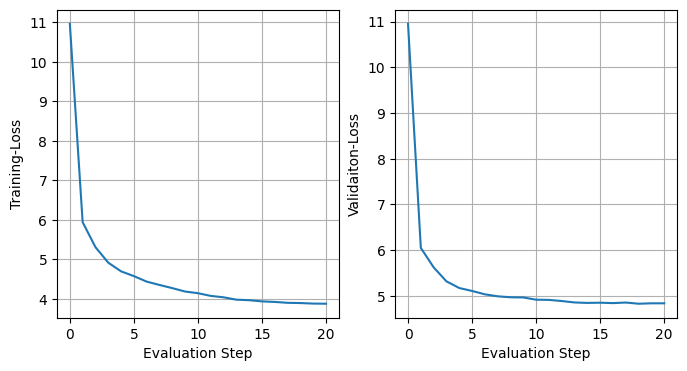

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(8,4),sharex = True)
ax[0].plot(trLoss)
ax[0].grid()
ax[0].set_ylabel('Training-Loss')
ax[0].set_xlabel('Evaluation Step')
ax[1].plot(valLoss)
ax[1].grid()
ax[1].set_ylabel('Validaiton-Loss')
ax[1].set_xlabel('Evaluation Step')

In [7]:
model = NanoGPT(config,tokenizer._size_())
model.load_state_dict(torch.load(r'/kaggle/working/nanoGPT_tiktoken.pth',map_location=config.device))
model.to(config.device)
context = torch.zeros((1, 1), dtype=torch.long, device=config.device)
model_output = tokenizer.decode(model.generate(context, 10000).squeeze(0).cpu().tolist())

In [8]:
print(model_output)

! 'Good
Second Servingman:
We shall be buried like to round:
How, Roger one: we that is slain
righted thine are true or inf late die.


God all the king told your branches with him forget it.

' the royal good morrowwentcliff.

Second Keeper:
Second Citizen:
' the valiant, you for this endued keeps that come as you as I'll purchase
For I'll know the process chewping plainly's well lies:
 nurs,
This case, that you with all how stoop,
Nonehire, if you have as at him freely they do duke were used lies--
When I have supporterspp, why lay him to followers were reason think 'emper'd my most execution.
Pended,

In my brother!

Would be so old and I have all the fire.


AUTOLINGHAM:
will
Are climate himself, go and death to set down.
Convenient women as I get

CORIUS:
And with thee: be it does me
For then where a soldierola the lady will, fellow you,

And I would D payingts.

And too, I believe him to me,
Nor thou bear me thus decre last with the prince, sir;
That does GAUNrow; here! For an fi

In [9]:
output_file = r'/kaggle/working/demo_02.txt'

with open(output_file,'w') as f:
    f.write(model_output)